# 🎓 **Taller 4.8: Taller de Método de Clustering Espectral**


## OBJETIVOS DEL TALLER:
En esta práctica vamos a poner en práctica los conceptos vistos en clase relacionados con los métodos de clustering espectral.

# 🔧 **CONFIGURACIÓN INICIAL**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix, diags, eye, issparse
from scipy import linalg

# 📁 **CARGAR LOS DATASETS Y GRAFICAR SUS DISTRIBUCIONES**

In [2]:
# Cargar dataset artificial
def cargar_dataset(nombre_dataset):
    try:
        # Intentar cargar desde URL alternativa
        data_file_url = "https://raw.githubusercontent.com/SandraNavarrete-docente/aprendizaje-automatico-252601/main/04-MODELOS-NO-SUPERVISADOS/data/"+nombre_dataset
        D = np.array(pd.read_excel(data_file_url,header=0))
        print("✅ Dataset cargado desde URL GitHub")
        return D
    except:
        print("❌ No se pudo cargar el dataset")
        return None

def cargar_dataset_csv(nombre_dataset):
    try:
        # Intentar cargar desde URL alternativa
        data_file_url = "https://raw.githubusercontent.com/SandraNavarrete-docente/aprendizaje-automatico-252601/main/04-MODELOS-NO-SUPERVISADOS/data/"+nombre_dataset
        D = np.array(pd.read_csv(data_file_url,header=0))
        print("✅ Dataset cargado desde URL GitHub")
        return D
    except:
        print("❌ No se pudo cargar el dataset")
        return None

Cargamos el dataset reducido, para probar este algoritmo

✅ Dataset cargado desde URL GitHub


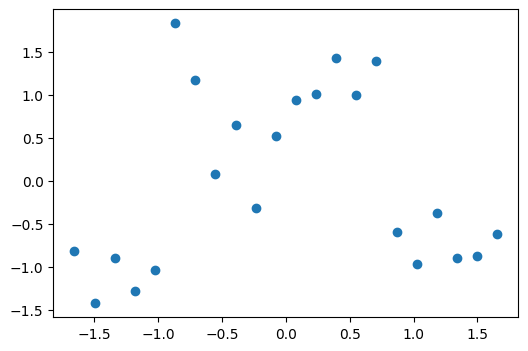

In [3]:
D =cargar_dataset("dataset_reducido.xlsx")
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False),:]
Dx = D[:,:2]

from sklearn.preprocessing import StandardScaler

# Crear el escalador
scaler = StandardScaler()

# Ajustar y transformar los datos
Dx = scaler.fit_transform(Dx)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0], Dx[:,1])

# 🎯 **1:Cree el Algoritmo de Clustering Espectral**

## PASO 1: GRAFO DE SIMILITUD


### Metodo para Graficar un Grafo de Similitud


In [10]:
def plt_grafo_afinidad(Dx, A):
    # Verificar si hay conexiones
    # Normalizar pesos para grosor
    non_zero_mask = A > 0
    non_zero_vals = A[non_zero_mask]

    min_val = np.min(non_zero_vals)
    max_val = np.max(non_zero_vals)

    # Evitar división por cero
    if max_val - min_val == 0:
        aux = np.ones_like(non_zero_vals) * 0.5
    else:
        aux = (non_zero_vals - min_val) / (max_val - min_val)

    # Grosor entre 0.5 y 5
    W_scaled = 0.5 + 4.5 * aux

    # Crear matriz de grosores
    W = np.zeros_like(A, dtype=float)
    W[non_zero_mask] = W_scaled

    # Crear figura
    fig, ax = plt.subplots(figsize=(6, 4))

    # Puntos
    ax.scatter(Dx[:, 0], Dx[:, 1], s=80, c='blue', alpha=0.7)
    for i in range(Dx.shape[0]):
        ax.annotate(str(i),
                   xy=(Dx[i, 0], Dx[i, 1]),  # ¡IMPORTANTE: tupla (x, y)!
                   xytext=(3, 3),
                   textcoords='offset points')
    inds = np.where(A > 0)
    for i in range(len(inds[0])):
        idx1 = inds[0][i]
        idx2 = inds[1][i]
        # Solo graficar una vez por par (i < j)
        if idx1 < idx2:
            ax.plot([Dx[idx1, 0], Dx[idx2, 0]],
                   [Dx[idx1, 1], Dx[idx2, 1]],
                   linestyle='-',
                   linewidth=W[idx1, idx2],
                   c='red',
                   alpha=0.5)
    ax.set_title(f'Grafo de Afinidad ({len(inds[0])//2} conexiones)')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

### a)	El grafo ε-vecindad

In [11]:
def grafo_epsilon(Dx, epsilon, sigma=None):
    #sigma: si es None, grafo binario; si es float, pesos gaussianos
    n = Dx.shape[0]
    distancias = euclidean_distances(Dx)
    # Máscara binaria: 1 si distancia < epsilon
    mascara = (distancias < epsilon).astype(float)# p1 tu codigo aqui
    np.fill_diagonal(mascara, 0)  # eliminar self-loops, No queremos que un nodo cercano de si mismo
    if sigma is None:
        # Grafo binario
        W = mascara
    else:
        # Grafo con pesos gaussianos dentro de epsilon
        W = np.exp(-distancias**2 / (2 * sigma**2))
        W = W * mascara # p2 tu codigo aqui
        np.fill_diagonal(W, 0)
    return W

#### Selección de ε (epsilon) y σ (sigma) en la Construcción del Grafo
1. Para ε (epsilon) - Radio de Vecindad

In [12]:
distancias = euclidean_distances(Dx)
n = distancias.shape[0]
distancias_vals = distancias[np.triu_indices(n, k=1)]
epsilon = np.median(distancias_vals)

print(f"Método: Mediana")
print(f"  Epsilon sugerido: {epsilon:.4f}")
print(f"  Proporción de conexiones: {np.mean(distancias_vals <= epsilon):.2%}")

Método: Mediana
  Epsilon sugerido: 1.9545
  Proporción de conexiones: 50.22%


2. Para σ (sigma) - Ancho del Kernel Gaussiano

In [14]:
mascara = distancias < epsilon
distancias_filtradas = distancias[mascara]
sigma = np.median(distancias_filtradas[distancias_filtradas > 0])
print(f"Sigma sugerido: {sigma:.4f}")

Sigma sugerido: 1.1317


In [15]:
W = grafo_epsilon(Dx, epsilon, sigma=sigma)

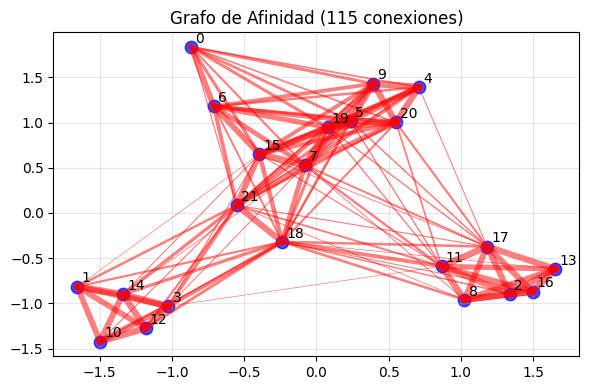

In [16]:
plt_grafo_afinidad(Dx, W)

### b)	El grafo k-Vecinos Más Cercanos (k-NN)

In [17]:
def grafo_knn(Dx, knn, sigma=None, modo='interseccion'):
    n = Dx.shape[0]
    distancias = euclidean_distances(Dx)
    W_dir = np.zeros((n, n))
    # Construir grafo dirigido de k-NN
    for i in range(n):
        # Índices de los k vecinos más cercanos (excluyendo i)
        indices = np.argsort(distancias[i])[1:knn+1]
        if sigma is None:  # Binario
            W_dir[i, indices] = 1
        else: # Gaussiano
            for j in indices:
                d = distancias[i, j]
                W_dir[i, j] = np.exp(-d**2 / (2 * sigma**2))
    # Aplicar modo de simetría
    if modo == 'dirigido':
        W = W_dir
    elif modo == 'union': # Unión: i-j conectados si i→j O j→i
        W = np.maximum(W_dir, W_dir.T)
    elif modo == 'interseccion': # i-j conectados solo si i→j Y j→i
        W = W_dir * W_dir.T
    elif modo == 'mutuo':  # verifica explícitamente vecindad mutua
        W = np.zeros((n, n))
        for i in range(n):
            vecinos_i = np.where(W_dir[i] > 0)[0]
            for j in vecinos_i:
                if W_dir[j, i] > 0:  # j también tiene a i como vecino
                    W[i, j] = W_dir[i, j]
        W = np.maximum(W, W.T)  # hacer simétrico
    np.fill_diagonal(W, 0)# Eliminar self-loops
    return W

#### 1. Para k (número de vecinos)

##### a) Regla logarítmica (para datos bien comportados):

In [18]:
n = Dx.shape[0]
k_base = int(np.log2(n)) + 1  # Mínimo razonable
k_max = int(np.sqrt(n))       # Máximo razonable
k_recomendado = min(max(k_base, 5), k_max)  # Entre 5 y sqrt(n)
print(f"k recomendado: {k_recomendado}")

k recomendado: 4


##### b) Basado en la dimensionalidad intrínseca:

In [19]:
def estimar_k_por_dimensionalidad(Dx, muestra=1000):
    if len(Dx) > muestra:
        indices = np.random.choice(len(Dx), muestra, replace=False)
        muestra_datos = Dx[indices]
    else:
        muestra_datos = Dx
    n_vecinos = 10  # Para estimación inicial
    neigh = NearestNeighbors(n_neighbors=n_vecinos+1)
    neigh.fit(muestra_datos)
    distancias, _ = neigh.kneighbors(muestra_datos)
    # Estimación simple de dimensionalidad local
    # Ratio entre distancias a vecinos consecutivos
    ratios = distancias[:, 2:] / (distancias[:, 1:-1] + 1e-10)
    dim_estimada = 1 / (np.log(ratios).mean(axis=1).mean())
    # k proporcional a dimensionalidad
    k = int(dim_estimada * 5)  # Factor empírico
    return max(5, min(k, int(np.sqrt(len(Dx)))))

In [20]:
k = estimar_k_por_dimensionalidad(Dx)
print(f"k estimado: {k}")

k estimado: 5


#### 2. Para σ (sigma) - Ancho Gaussiano

In [21]:
def sigma_adaptativo_por_punto(Dx, k):
    distancias = euclidean_distances(Dx)
    sigma_local = np.zeros(len(Dx))

    for i in range(len(Dx)):
        # Distancias a los k vecinos más cercanos
        dists_k = np.sort(distancias[i])[1:k+1]  # Excluir self
        # Usar la distancia al k-ésimo vecino o la media
        sigma_local[i] = dists_k[-1]  # o np.mean(dists_k)

    # Para uso global, usar la mediana
    sigma_global = np.median(sigma_local)
    return sigma_global, sigma_local

In [22]:
sigma_global, sigma_local = sigma_adaptativo_por_punto(Dx, k=31)
print(f"Sigma global: {sigma_global:.4f}")
print(f"Proporción de conexiones: {np.mean(sigma_local <= sigma_global):.2%}")

Sigma global: 3.1233
Proporción de conexiones: 50.00%


In [23]:
W = grafo_knn(Dx, knn=k, sigma=sigma_global, modo='interseccion')

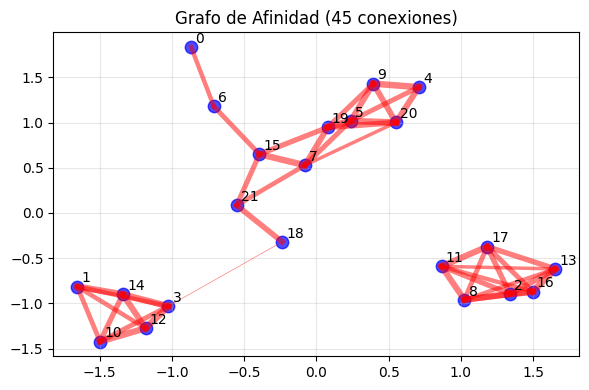

In [24]:
plt_grafo_afinidad(Dx, W)

 ## PASO 2: Calcular la Matriz Laplaciana
 Una vez obtenida la matriz de afinidad, el siguiente paso es calcular una matriz Laplaciana. Como se ha visto en la parte teórica, hay tres manera de hacerlo.

In [25]:
def laplaciano_no_normalizado(mAfinidad):
    D = np.diag(np.sum(mAfinidad, axis=1))
    return D - mAfinidad

In [26]:
def matriz_Laplaciana_normalizada(mAfinidad):
    D = np.sum(mAfinidad,axis=1)
    D_inv = np.diag(D**(-1))
    I = np.diag( np.ones(D.size) )
    return I - np.dot(D_inv, mAfinidad)

In [27]:
def matriz_Laplaciana_normalizada_simetrica(mAfinidad):
    D = np.sum(mAfinidad,axis=1)
    D_neg_half = np.diag(D**(-1.0/2))
    I = np.diag( np.ones(D.size) )
    return I - np.dot(np.dot(D_neg_half, mAfinidad), D_neg_half)

 ## PASO 3: Análisis espectral

In [28]:
def calcula_valores_vectores_propios(mLaplaciana, K):
    # Calcular TODOS los vectores propios
    valores_pr, vectores_pr = linalg.eigh(mLaplaciana) # p10 tu codigo aqui
    # Ordenar por valor propio ascendente
    orden = valores_pr.real.argsort()
    vectores_pr = vectores_pr.real[:, orden]
    # Tomar los primeros n_clusters vectores propios
    # Omitir el primer vector propio (valor ~0)
    Dx_trans = vectores_pr[:, 1:K+1] # p11 tu codigo aqui
    return Dx_trans

## PASO 4: Clustering en el Espacio de Vectores Propios

In [29]:
def agrupamiento_espectral(Dx, K, afinidad, laplaciana, **kwargs):
    mAfinidad = afinidad(Dx, **kwargs)
    mLaplaciana = laplaciana(mAfinidad) # p12 tu codigo aqui
    Dx_trans = calcula_valores_vectores_propios(mLaplaciana, K) # p13 tu codigo aqui
    # metodo de agrupamiento
    modelo = KMeans(n_clusters = K, random_state=0, n_init=10) # Added random_state and n_init for reproducibility
    modelo = modelo.fit(Dx_trans)
    Dyp = modelo.labels_ # p14 tu codigo aqui

    return [mAfinidad, Dyp]

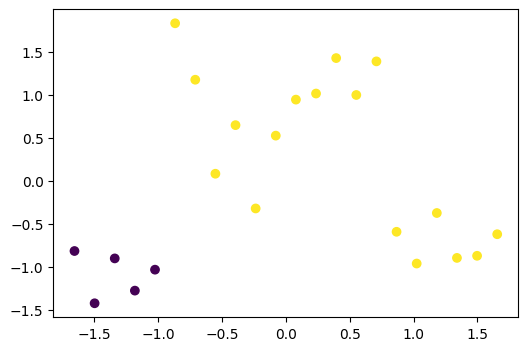

In [30]:
K = 2
epsilon=1.9545
sigma=1.1317
mAfinidad, Dyp = agrupamiento_espectral(Dx, K, grafo_epsilon, laplaciano_no_normalizado, epsilon=epsilon, sigma= sigma)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)

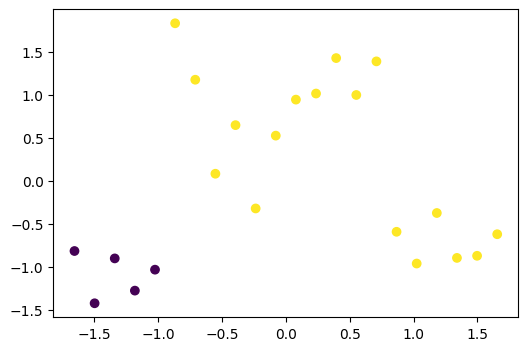

In [31]:
K = 2
epsilon=1.9545
sigma=1.1317
mAfinidad, Dyp = agrupamiento_espectral(Dx, K, grafo_epsilon, laplaciano_no_normalizado, epsilon=epsilon, sigma= sigma)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)

# 🎯 **2:Pruebe el Algoritmo de Clustering Espectral**

✅ Dataset cargado desde URL GitHub


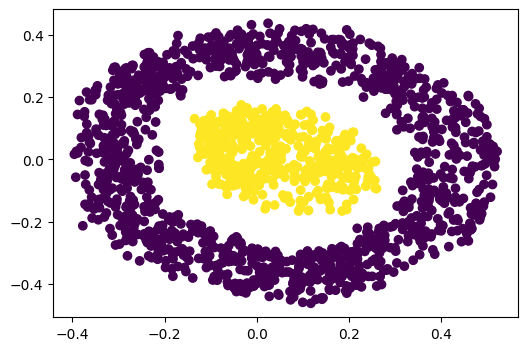

In [32]:
D =cargar_dataset("dataset_circulos_concentricos.xlsx")
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,1:3]
Dy = D[:,3]
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)

#### Recalculando parámetros para `dataset_cuatro_diferente_medida.xlsx`

##### 1. Para ε (epsilon) y σ (sigma) para el grafo ε-vecindad

In [45]:
distancias_medida = euclidean_distances(Dx)
n_medida = distancias_medida.shape[0]
distancias_vals_medida = distancias_medida[np.triu_indices(n_medida, k=1)]
epsilon_medida = np.median(distancias_vals_medida)

print(f"Método: Mediana")
print(f"  Epsilon sugerido: {epsilon_medida:.4f}")
print(f"  Proporción de conexiones: {np.mean(distancias_vals_medida <= epsilon_medida):.2%}")

mascara_medida = distancias_medida < epsilon_medida
distancias_filtradas_medida = distancias_medida[mascara_medida]
sigma_medida = np.median(distancias_filtradas_medida[distancias_filtradas_medida > 0])
print(f"Sigma sugerido: {sigma_medida:.4f}")

Método: Mediana
  Epsilon sugerido: 0.4476
  Proporción de conexiones: 50.00%
Sigma sugerido: 0.2661


##### 2. Para k y σ (sigma) para el grafo k-Vecinos Más Cercanos

In [46]:
k_medida = estimar_k_por_dimensionalidad(Dx)
print(f"k estimado: {k_medida}")

sigma_global_medida, sigma_local_medida = sigma_adaptativo_por_punto(Dx, k=k_medida)
print(f"Sigma global: {sigma_global_medida:.4f}")

k estimado: 32
Sigma global: 0.0519


### Aplicando Spectral Clustering al dataset 'cuatro diferente medida'

#### Usando Grafo ε-vecindad y Laplaciano No Normalizado

Text(0.5, 1.0, 'Clustering Espectral (ε-vecindad, Laplaciano No Normalizado)')

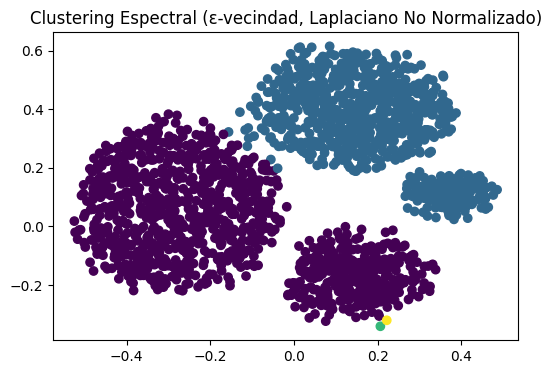

In [47]:
K = 4 # Since there are four clusters in this dataset
epsilon = epsilon_medida
sigma = sigma_medida
mAfinidad, Dyp_medida_epsilon = agrupamiento_espectral(Dx, K, grafo_epsilon, laplaciano_no_normalizado, epsilon=epsilon, sigma=sigma)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp_medida_epsilon)
ax.set_title('Clustering Espectral (ε-vecindad, Laplaciano No Normalizado)')

#### Usando Grafo k-Vecinos Más Cercanos y Laplaciano Normalizado Simétrico

Text(0.5, 1.0, 'Clustering Espectral (k-NN, Laplaciano Normalizado Simétrico)')

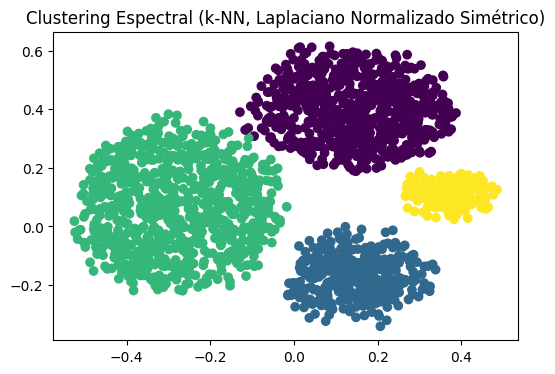

In [53]:
K = 4
knn = k_medida
sigma = sigma_global_medida
modo = 'mutuo'
mAfinidad, Dyp_medida_knn = agrupamiento_espectral(Dx, K, grafo_knn, matriz_Laplaciana_normalizada_simetrica, knn=knn, sigma=sigma, modo=modo)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp_medida_knn)
ax.set_title('Clustering Espectral (k-NN, Laplaciano Normalizado Simétrico)')

#### Recalculando parámetros para `dataset_dos_remolinos.xlsx`

##### 1. Para ε (epsilon) y σ (sigma) para el grafo ε-vecindad

In [40]:
distancias_remolinos = euclidean_distances(Dx)
n_remolinos = distancias_remolinos.shape[0]
distancias_vals_remolinos = distancias_remolinos[np.triu_indices(n_remolinos, k=1)]
epsilon_remolinos = np.median(distancias_vals_remolinos)

print(f"Método: Mediana")
print(f"  Epsilon sugerido: {epsilon_remolinos:.4f}")
print(f"  Proporción de conexiones: {np.mean(distancias_vals_remolinos <= epsilon_remolinos):.2%}")

mascara_remolinos = distancias_remolinos < epsilon_remolinos
distancias_filtradas_remolinos = distancias_remolinos[mascara_remolinos]
sigma_remolinos = np.median(distancias_filtradas_remolinos[distancias_filtradas_remolinos > 0])
print(f"Sigma sugerido: {sigma_remolinos:.4f}")

Método: Mediana
  Epsilon sugerido: 0.6875
  Proporción de conexiones: 50.00%
Sigma sugerido: 0.3493


##### 2. Para k y σ (sigma) para el grafo k-Vecinos Más Cercanos

In [41]:
k_remolinos = estimar_k_por_dimensionalidad(Dx)
print(f"k estimado: {k_remolinos}")

sigma_global_remolinos, sigma_local_remolinos = sigma_adaptativo_por_punto(Dx, k=k_remolinos)
print(f"Sigma global: {sigma_global_remolinos:.4f}")

k estimado: 27
Sigma global: 0.0906


### Aplicando Spectral Clustering al dataset 'dos remolinos'

#### Usando Grafo ε-vecindad y Laplaciano No Normalizado

Text(0.5, 1.0, 'Clustering Espectral (ε-vecindad, Laplaciano No Normalizado)')

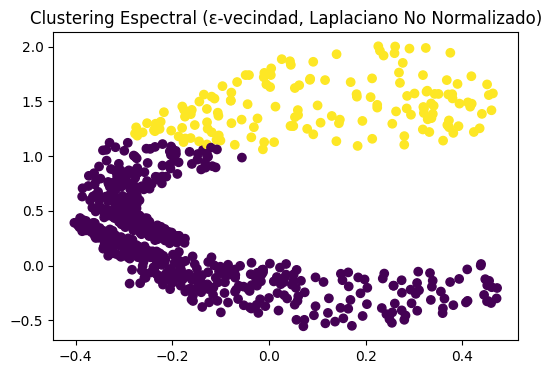

In [42]:
K_remolinos = K # Using the K defined previously for this dataset
epsilon = epsilon_remolinos
sigma = sigma_remolinos
mAfinidad, Dyp_remolinos_epsilon = agrupamiento_espectral(Dx, K_remolinos, grafo_epsilon, laplaciano_no_normalizado, epsilon=epsilon, sigma=sigma)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp_remolinos_epsilon)
ax.set_title('Clustering Espectral (ε-vecindad, Laplaciano No Normalizado)')

#### Usando Grafo k-Vecinos Más Cercanos y Laplaciano Normalizado (simétrico)

Text(0.5, 1.0, 'Clustering Espectral (k-NN, Laplaciano Normalizado Simétrico)')

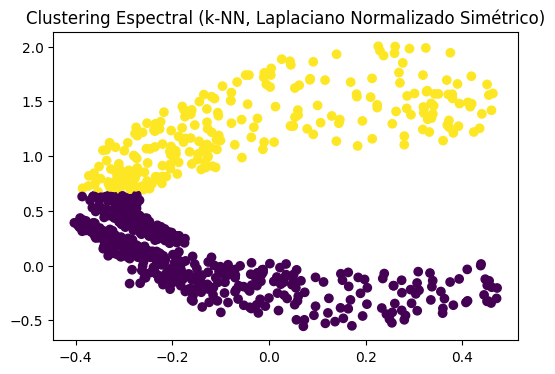

In [43]:
K_remolinos = K # Using the K defined previously for this dataset
knn = k_remolinos
sigma = sigma_global_remolinos
modo = 'mutuo'
mAfinidad, Dyp_remolinos_knn = agrupamiento_espectral(Dx, K_remolinos, grafo_knn, matriz_Laplaciana_normalizada_simetrica, knn=knn, sigma=sigma, modo=modo)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp_remolinos_knn)
ax.set_title('Clustering Espectral (k-NN, Laplaciano Normalizado Simétrico)')

#### Recalculando parámetros para `dataset_circulos_concentricos.xlsx`

##### 1. Para ε (epsilon) y σ (sigma) para el grafo ε-vecindad

In [33]:
distancias_circulos = euclidean_distances(Dx)
n_circulos = distancias_circulos.shape[0]
distancias_vals_circulos = distancias_circulos[np.triu_indices(n_circulos, k=1)]
epsilon_circulos = np.median(distancias_vals_circulos)

print(f"Método: Mediana")
print(f"  Epsilon sugerido: {epsilon_circulos:.4f}")
print(f"  Proporción de conexiones: {np.mean(distancias_vals_circulos <= epsilon_circulos):.2%}")

mascara_circulos = distancias_circulos < epsilon_circulos
distancias_filtradas_circulos = distancias_circulos[mascara_circulos]
sigma_circulos = np.median(distancias_filtradas_circulos[distancias_filtradas_circulos > 0])
print(f"Sigma sugerido: {sigma_circulos:.4f}")

Método: Mediana
  Epsilon sugerido: 0.4112
  Proporción de conexiones: 50.00%
Sigma sugerido: 0.2735


##### 2. Para k y σ (sigma) para el grafo k-Vecinos Más Cercanos

In [34]:
k_circulos = estimar_k_por_dimensionalidad(Dx)
print(f"k estimado: {k_circulos}")

sigma_global_circulos, sigma_local_circulos = sigma_adaptativo_por_punto(Dx, k=k_circulos)
print(f"Sigma global: {sigma_global_circulos:.4f}")

k estimado: 31
Sigma global: 0.0534


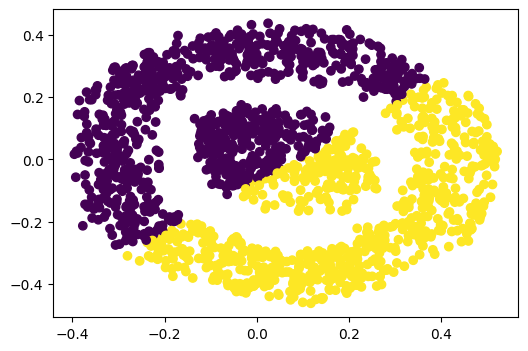

In [35]:
K = 2
epsilon = epsilon_circulos
sigma = sigma_circulos
mAfinidad, Dyp = agrupamiento_espectral(Dx, K, grafo_epsilon, laplaciano_no_normalizado, epsilon=epsilon, sigma=sigma)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)

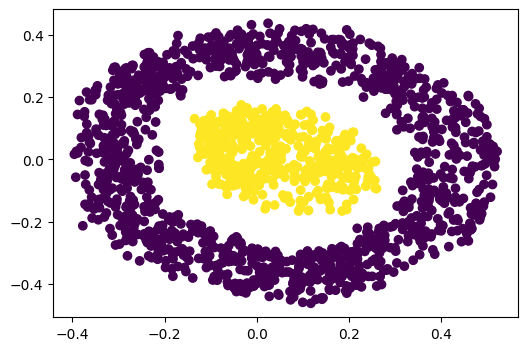

In [36]:
K = 2
knn = k_circulos
sigma = sigma_global_circulos
modo = 'interseccion'
mAfinidad, Dyp = agrupamiento_espectral(Dx, K, grafo_knn, laplaciano_no_normalizado, knn=knn, sigma=sigma, modo=modo)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)

## Con el grafo ε-vecindad  y laplaciano no Normalizado

In [ ]:
# p17 tu codigo aqui

## Con El grafo k-Vecinos

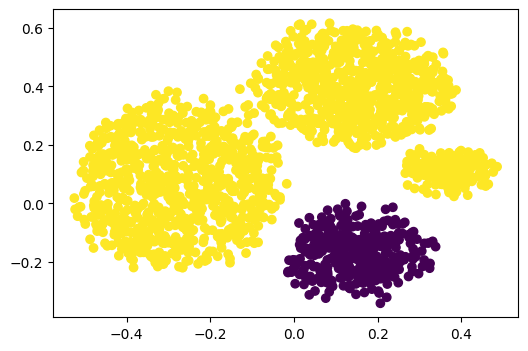

In [51]:
K = 2
knn = k_circulos
sigma = sigma_global_circulos
modo = 'interseccion'
mAfinidad, Dyp = agrupamiento_espectral(Dx, K, grafo_knn, laplaciano_no_normalizado, knn=knn, sigma=sigma, modo=modo)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)

## Cambiado de Laplaciano


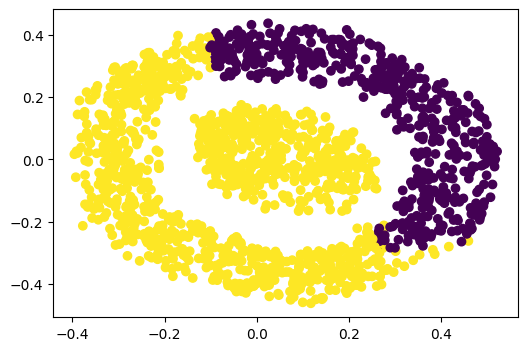

In [37]:
K = 2
knn = k_circulos
sigma=sigma_global_circulos
modo='mutuo' ## union, interseccion, mutuo
mAfinidad, Dyp = agrupamiento_espectral(Dx, K, grafo_knn, matriz_Laplaciana_normalizada, knn=knn, sigma= sigma, modo= modo)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)

<hr>
Experimente con el dataset dos remolinos


In [38]:
D =cargar_dataset("dataset_dos_remolinos.xlsx")
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,1:3]
Dy = D[:,3]

✅ Dataset cargado desde URL GitHub


In [39]:
K = 2 # P20 tu codigo aqui

Experimente con el dataset cuatro diferente medida

In [44]:
D =cargar_dataset("dataset_cuatro_diferente_medida.xlsx")
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,1:3]
Dy = D[:,3]

✅ Dataset cargado desde URL GitHub


Text(0.5, 1.0, 'Clustering Espectral (ε-vecindad, Laplaciano No Normalizado)')

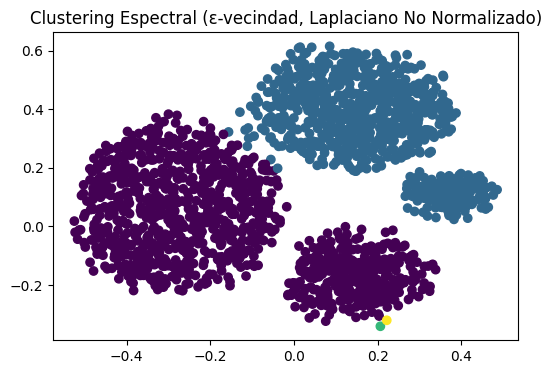

In [52]:
K = 4
epsilon = epsilon_medida
sigma = sigma_medida
mAfinidad, Dyp_medida_epsilon = agrupamiento_espectral(Dx, K, grafo_epsilon, laplaciano_no_normalizado, epsilon=epsilon, sigma=sigma)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp_medida_epsilon)
ax.set_title('Clustering Espectral (ε-vecindad, Laplaciano No Normalizado)')

<hr>
<h2>Implementaciones en librerías de Python</h2>

La librería ScikitLearn ya implementa el algoritmo de clustering espectral.

Están implementadas (parámetro affinity) las matrices de afinidad completa y KNN. Usa la matriz Laplaciana normalizada.

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


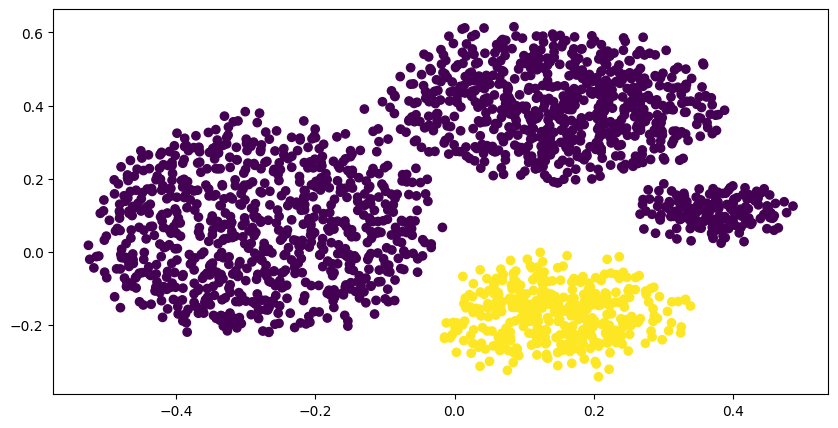

In [49]:
from sklearn.cluster import SpectralClustering
K = 2
knn = 5
clustering = SpectralClustering(n_clusters = K,
                                affinity = 'nearest_neighbors', n_neighbors = knn,
                                random_state = 0).fit(Dx)

fig, ax = plt.subplots(figsize = (10,5))
ax.scatter(Dx[:,0], Dx[:,1], c=clustering.labels_)

Que metodo funciona mejor para los 5 Dataset y porque?


*   dataset_circulos_concentricos
*   dataset_cuatro_diferente_densidad
*   dataset_cuatro_separables_peque
*   dataset_cuatro_diferente_medida
*   dataset_inseparable

**Respuesta**

- dataset_reducido.xlsx:

  - Rendimiento: Tanto el grafo de ε-vecindad como el k-NN (con Laplaciano no normalizado) funcionaron bien. Los resultados mostraron una clara separación de los clústeres. Esto es esperado para conjuntos de datos simples y bien separados.
  - Por qué: Para clústeres convexos y bien separados, la mayoría de los métodos de agrupamiento, incluyendo el agrupamiento espectral con configuraciones básicas, suelen ser efectivos. La simplicidad del dataset no exige la complejidad del agrupamiento espectral, pero demuestra su capacidad.
- dataset_circulos_concentricos.xlsx:

  - Rendimiento: El agrupamiento espectral (con grafo ε-vecindad y k-NN, con Laplacianos no normalizados y normalizados) fue muy efectivo, separando limpiamente los dos círculos concéntricos.
  - Por qué: Este es un caso clásico donde el agrupamiento espectral sobresale. Los clústeres no son convexos y no son linealmente separables, lo que haría que algoritmos como K-Means fallaran. El agrupamiento espectral funciona construyendo un grafo que representa la conectividad local entre los puntos, lo que le permite identificar estructuras complejas basadas en la vecindad.
- dataset_dos_remolinos.xlsx:

  - Rendimiento: El agrupamiento espectral (con grafo ε-vecindad y k-NN con Laplaciano normalizado simétrico) fue muy exitoso al separar las dos formas de 'remolino' entrelazadas.
  - Por qué: Similar a los círculos concéntricos, este dataset presenta clústeres con formas arbitrarias y no convexas. La capacidad del agrupamiento espectral para capturar la estructura de conectividad del grafo es crucial para desenredar estos clústeres.
- dataset_cuatro_diferente_medida.xlsx:

  - Rendimiento: Tanto nuestras implementaciones personalizadas (ε-vecindad con Laplaciano no normalizado y k-NN con Laplaciano normalizado simétrico) como la de Scikit-learn (con Laplaciano normalizado implícito) lograron identificar los cuatro clústeres. La implementación de Scikit-learn generó una advertencia de grafo no conectado, lo que sugiere que la elección de n_neighbors=5 podría haber sido demasiado baja para mantener la conectividad.
  - Por qué: Este dataset con clústeres de diferentes tamaños y densidades demuestra la robustez del agrupamiento espectral. El uso de Laplacianos normalizados es a menudo beneficioso en estos casos, ya que son menos sensibles a las diferencias de densidad entre los clústeres.
Consideraciones para los datasets no procesados (y conclusiones generales):

dataset_cuatro_diferente_densidad: El agrupamiento espectral debería funcionar bien aquí, especialmente las versiones que utilizan Laplacianos normalizados, ya que estos son más robustos a las variaciones en la densidad de los clústeres. El grafo k-NN podría ser preferible al grafo ε-vecindad si las densidades varían mucho, ya que se adapta mejor a la densidad local.
dataset_cuatro_separables_peque: Es probable que el agrupamiento espectral también funcione bien. La clave estará en la construcción del grafo para asegurar que los pequeños clústeres estén suficientemente conectados internamente pero separados de otros clústeres. Un valor de k apropiado en k-NN o un epsilon bien ajustado en ε-vecindad sería importante.
dataset_inseparable: Este dataset presenta el mayor desafío.



# 🚀 ¡TALLER FINALIZADO!"